In [1]:
# The code was removed by Watson Studio for sharing.

# Week 4 - Battle of the Neighbourhoods Assignment (Part 2)

## Tasks: 

1. A full report consisting of all of the following components (15 marks): 
Introduction where you discuss the business problem and who would be interested in this project.
Data where you describe the data that will be used to solve the problem and the source of the data.
Methodology section which represents the main component of the report where you discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, and what machine learnings were used and why.
Results section where you discuss the results.
Discussion section where you discuss any observations you noted and any recommendations you can make based on the results.
Conclusion section where you conclude the report.
1. A link to your Notebook on your Github repository pushed showing your code. (15 marks)

1. Your choice of a presentation or blogpost. (10 marks)

### Import necessary libraries

In [2]:
import pandas as pd
import numpy as np

!pip install "uszipcode";# library that provide zipcode related data
from uszipcode import SearchEngine, SimpleZipcode, Zipcode

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from geopy.geocoders import Nominatim

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# normalize dataset
from sklearn.preprocessing import StandardScaler

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes;# uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

    100% |████████████████████████████████| 143kB 5.5MB/s eta 0:00:01
    100% |████████████████████████████████| 204kB 4.5MB/s eta 0:00:01
Requirement not upgraded as not directly required: requests in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from uszipcode)
Requirement not upgraded as not directly required: sqlalchemy in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from uszipcode)
    100% |████████████████████████████████| 122kB 6.9MB/s eta 0:00:01
Requirement not upgraded as not directly required: six in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from pathlib-mate->uszipcode)
Requirement not upgraded as not directly required: chardet<3.1.0,>=3.0.2 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests->uszipcode)
Requirement not upgraded as not directly required: idna<2.7,>=2.5 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests->uszipcode)
Requirement not upgraded as not directly required: urll

###  Obtain Boston's zipcodes from Boston.gov and use `uszipcode` package to populate latitude, longitude, population density and median home value

Extract list of Boston zipcodes from csv file and remove duplicates from the list. Subsequently, to obtain the required data (name, latitutde, longitude, population density and median home value) associated with each zip code using `uszipcode`.

Note that zipcodes in Central Boston do not map to a specific neighbourhood name (limitation of the `uszipcode` package). To bypass this issue, subsequently label each point on map by combination of both its zipcode and name.

### How data will be used:
1. Latitude and Longitude data will be used as inputs to obtain Foursquare data. 
1. Population density and median home value data will be used subsequently to cluster the neighbourhoods. 


In [3]:
# open file with data of Boston neighbourhoods (obtained from Boston's official website)
boston_df = pd.read_csv(project.get_file('ZIP_Codes.csv'), dtype={'ZIP5': 'str'})
boston_df = boston_df[['ZIP5']].drop_duplicates() # remove duplicates from list
# create additional columns
boston_df['Name'] = 'Name'
boston_df['Latitude'] = 0.0
boston_df['Longitude'] = 0.0
boston_df['Population_Density'] = 0
boston_df['Median_Home_Value'] = 0
boston_df.head()

,ZIP5,Name,Latitude,Longitude,Population_Density,Median_Home_Value
0,02134,Name,0.0,0.0,0,0
1,02125,Name,0.0,0.0,0,0
2,02110,Name,0.0,0.0,0,0
3,02118,Name,0.0,0.0,0,0
4,02126,Name,0.0,0.0,0,0


In [4]:
# define function to get data for each row in Dataframe using uszipcode
def get_zipcode_data(row): 
    search = SearchEngine(simple_zipcode=True) # set simple_zipcode=False to use rich info database
    zipcode = search.by_zipcode(row['ZIP5'])
    name = zipcode.major_city
    lat = zipcode.lat
    lng = zipcode.lng
    pop_density = zipcode.population_density
    median_value = zipcode.median_home_value
    
    return [zipcode.zipcode, name, lat, lng, pop_density, median_value]

boston_df = boston_df.apply(get_zipcode_data, axis=1).dropna().reset_index(drop=True) # drop rows with NaN

print('Total number of zipcodes in Boston = ', boston_df.shape[0])

boston_df.head()

Start downloading data for simple zipcode database, total size 9MB ...
  1 MB finished ...
  2 MB finished ...
  3 MB finished ...
  4 MB finished ...
  5 MB finished ...
  6 MB finished ...
  7 MB finished ...
  8 MB finished ...
  9 MB finished ...
  10 MB finished ...
  Complete!
Total number of zipcodes in Boston =  35


,ZIP5,Name,Latitude,Longitude,Population_Density,Median_Home_Value
0,02134,Allston,42.360,-71.130,16212.0,361900.0
1,02125,Dorchester,42.320,-71.000,15611.0,301200.0
2,02110,Boston,42.359,-71.054,9355.0,724000.0
3,02118,Boston,42.340,-71.070,24075.0,561100.0
4,02126,Mattapan,42.280,-71.090,12277.0,282700.0


### Visualise the distribution of population density and median home values

From the histograms, we can see that median home values and population density are distributed on the lower range across quite a number of zipcodes. 

In [5]:
boston_df.hist(column=['Population_Density'])
boston_df.hist(column=['Median_Home_Value'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fda0805b9b0>]], dtype=object)

### Visualise Boston and its neighbourhoods

In [6]:
address = 'Boston'

geolocator = Nominatim(user_agent="boston_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Boston are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Boston are 42.3602534, -71.0582912.


In [7]:
# create map of Boston using latitude and longitude values
map_boston = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label, zipcode in zip(boston_df['Latitude'], boston_df['Longitude'], boston_df['Name'], boston_df['ZIP5']):
    combined_label = zipcode + " " + label
    label = folium.Popup(combined_label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=True).add_to(map_boston)  
    
map_boston

### Access Foursquare data to get venue information

### How data will be used:
1. Each zipcode will subsequently be analysed to establish which one has the most diverse range of services.
1. Clustering will also be carried out to identify groups of similar zipcodes

In [8]:
# The code was removed by Watson Studio for sharing.

In [9]:
# Reuse function from lab to get nearby venues near each Borough
def getNearbyVenues(ZIP5, names, latitudes, longitudes, radius=500):
    
    LIMIT = 200
    venues_list=[]
    for zip5, name, lat, lng in zip(ZIP5, names, latitudes, longitudes):
        print(len(venues_list), " ", zip5, " " ,name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            zip5,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['ZIP5',
                  'Name',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
boston_venues = getNearbyVenues(ZIP5=boston_df['ZIP5'], 
                                names=boston_df['Name'],
                                latitudes=boston_df['Latitude'],
                                longitudes=boston_df['Longitude']
                                )

0   02134   Allston
1   02125   Dorchester
2   02110   Boston
3   02118   Boston
4   02126   Mattapan
5   02109   Boston
6   02021   Canton
7   02113   Boston
8   02130   Jamaica Plain
9   02121   Dorchester
10   02119   Roxbury
11   02115   Boston
12   02135   Brighton
13   02199   Boston
14   02459   Newton Center
15   02124   Dorchester Center
16   02132   West Roxbury
17   02114   Boston
18   02108   Boston
19   02136   Hyde Park
20   02111   Boston
21   02210   Boston
22   02116   Boston
23   02131   Roslindale
24   02127   Boston
25   02120   Roxbury Crossing
26   02215   Boston
27   02129   Charlestown
28   02128   Boston
29   02122   Dorchester
30   02151   Revere
31   02186   Milton
32   02026   Dedham
33   02152   Winthrop
34   02467   Chestnut Hill


In [11]:
boston_venues.head()

,ZIP5,Name,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,02134,Allston,42.36,-71.13,Trader Joe's,42.363344,-71.129944,Grocery Store
1,02134,Allston,42.36,-71.13,Boston Liquors,42.358027,-71.126793,Liquor Store
2,02134,Allston,42.36,-71.13,swissbäkers,42.363194,-71.128565,Bakery
3,02134,Allston,42.36,-71.13,Our Fathers Deli,42.363520,-71.129458,Bar
4,02134,Allston,42.36,-71.13,The Breakfast Club,42.363326,-71.133548,Diner


### Total venues and unique venue categories, and top 10 venue categories in Boston

In [12]:
print('Unique venue categories in Boston is {}'.format(len(boston_venues['Venue Category'].unique())))
print('Total venues in Boston is {}'.format(len(boston_venues['Venue Category'])))

Unique venue categories in Boston is 209
Total venues in Boston is 1291


Top 10 venue categories in Boston


,Venue Category
Italian Restaurant,105
Coffee Shop,55
Seafood Restaurant,44
American Restaurant,40
Pizza Place,39
Bakery,33
Park,28
Donut Shop,27
Café,27
Hotel,26


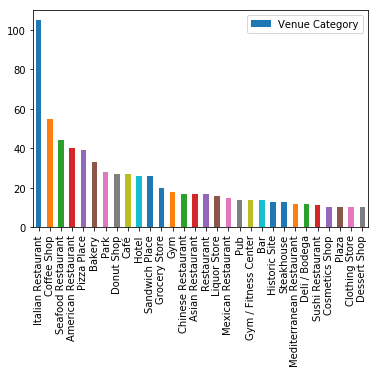

In [13]:
print('Top 10 venue categories in Boston')
 
top_venues = pd.DataFrame(boston_venues['Venue Category'].value_counts()[0:30])
top_10_list = top_venues.index.tolist()[0:10]

top_venues.plot(y='Venue Category', kind='bar')
top_venues.head(10)

### Analyze number of venues in each neighborhood

In [14]:
# Group neighborhoods and count total venues in each neighborhood
grouped_venue_total = boston_venues.groupby(by='ZIP5', as_index=False).count()

# Join name of neighborhood and sort
grouped_venue_total = grouped_venue_total[['ZIP5','Venue']].join(boston_df[['ZIP5','Name']].set_index('ZIP5'), on='ZIP5').sort_values('Venue', ascending=False)
grouped_venue_total = grouped_venue_total.reset_index(drop=True)
grouped_venue_total = grouped_venue_total[['ZIP5', 'Name', 'Venue']]
grouped_venue_total.head()

,ZIP5,Name,Venue
0,02116,Boston,100
1,02108,Boston,100
2,02109,Boston,100
3,02110,Boston,100
4,02111,Boston,100


### Analyze unique venue categories in each neighborhood

In [15]:
# Group neighborhoods and count unique venue categories in each neighborhood
grouped_venue_cat = boston_venues.groupby(by='ZIP5', as_index=False).agg({'Venue Category': pd.Series.nunique})

# Join name of neighborhood and sort
grouped_venue_cat = grouped_venue_cat.join(boston_df[['ZIP5','Name']].set_index('ZIP5'), on='ZIP5').sort_values('Venue Category', ascending=False)
grouped_venue_cat = grouped_venue_cat.reset_index(drop=True)
grouped_venue_cat = grouped_venue_cat[['ZIP5', 'Name', 'Venue Category']]
grouped_venue_cat.head()

,ZIP5,Name,Venue Category
0,02199,Boston,63
1,02108,Boston,60
2,02116,Boston,58
3,02110,Boston,55
4,02111,Boston,49


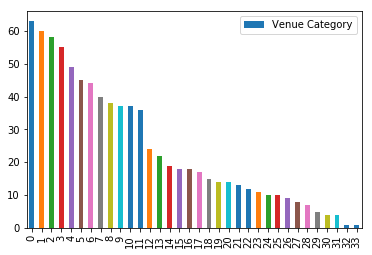

In [16]:
# Plot distribution of Venue categories by neighborhood
grouped_venue_cat.plot(y='Venue Category', kind='bar')

### Create dataframe for clustering

Use one-hot encoding on 'Venue Category' and select only the top 10 venues and subsequently group by 'ZIP5' to find mean.
Subsequently merge with earlier data to combine other parameters (Population density, Median Home Value).

In [17]:
# one hot encoding
boston_onehot = pd.get_dummies(boston_venues[['Venue Category']], prefix="", prefix_sep="")
boston_onehot = boston_onehot[top_10_list] # only include top 10 venues as additional parameters to cluster together with total venue categories

# add ZIP5 and Name columns back to dataframe
boston_onehot['ZIP5'] = boston_venues['ZIP5']
boston_onehot['Name'] = boston_venues['Name']

# move last 2 columns to the first 2 columns
fixed_columns = [boston_onehot.columns[-2]] + [boston_onehot.columns[-1]] + list(boston_onehot.columns[:-2])
boston_onehot = boston_onehot[fixed_columns]

print('Number of rows and columns: ', boston_onehot.shape)
boston_onehot.head()

Number of rows and columns:  (1291, 12)


,ZIP5,Name,Italian Restaurant,Coffee Shop,Seafood Restaurant,American Restaurant,Pizza Place,Bakery,Park,Donut Shop,Café,Hotel
0,02134,Allston,0,0,0,0,0,0,0,0,0,0
1,02134,Allston,0,0,0,0,0,0,0,0,0,0
2,02134,Allston,0,0,0,0,0,1,0,0,0,0
3,02134,Allston,0,0,0,0,0,0,0,0,0,0
4,02134,Allston,0,0,0,0,0,0,0,0,0,0


In [18]:
# Find the mean number of the top 10 venues within each neighborhood
boston_grouped = boston_onehot.groupby('ZIP5').mean().reset_index()
boston_grouped

,ZIP5,Italian Restaurant,Coffee Shop,Seafood Restaurant,American Restaurant,Pizza Place,Bakery,Park,Donut Shop,Café,Hotel
0,02021,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
1,02026,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.100000,0.100000
2,02108,0.040000,0.040000,0.020000,0.050000,0.030000,0.000000,0.010000,0.000000,0.000000,0.020000
3,02109,0.340000,0.020000,0.070000,0.010000,0.040000,0.070000,0.030000,0.000000,0.030000,0.000000
4,02110,0.020000,0.080000,0.100000,0.020000,0.010000,0.020000,0.050000,0.010000,0.010000,0.060000
5,02111,0.020000,0.040000,0.020000,0.010000,0.020000,0.060000,0.000000,0.000000,0.020000,0.010000
6,02113,0.400000,0.030000,0.040000,0.010000,0.050000,0.060000,0.050000,0.000000,0.030000,0.010000
7,02114,0.047619,0.015873,0.000000,0.031746,0.079365,0.000000,0.000000,0.031746,0.015873,0.047619
8,02115,0.019231,0.076923,0.019231,0.038462,0.000000,0.000000,0.019231,0.038462,0.076923,0.000000
9,02116,0.040000,0.050000,0.040000,0.050000,0.000000,0.000000,0.010000,0.000000,0.010000,0.050000


In [19]:
# Add population density and median home value
boston_grouped = boston_grouped.join(boston_df[['ZIP5', 'Population_Density', 'Median_Home_Value']].set_index('ZIP5'), on='ZIP5')

# Add number of venue categories
boston_grouped = boston_grouped.join(grouped_venue_cat[['ZIP5', 'Venue Category']].set_index('ZIP5'), on='ZIP5')

boston_grouped.head()

,ZIP5,Italian Restaurant,Coffee Shop,Seafood Restaurant,American Restaurant,Pizza Place,Bakery,Park,Donut Shop,Café,Hotel,Population_Density,Median_Home_Value,Venue Category
0,02021,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1147.0,425800.0,1
1,02026,0.00,0.00,0.00,0.10,0.00,0.00,0.00,0.00,0.10,0.10,2412.0,373700.0,9
2,02108,0.04,0.04,0.02,0.05,0.03,0.00,0.01,0.00,0.00,0.02,27919.0,724500.0,60
3,02109,0.34,0.02,0.07,0.01,0.04,0.07,0.03,0.00,0.03,0.00,21721.0,676700.0,40
4,02110,0.02,0.08,0.10,0.02,0.01,0.02,0.05,0.01,0.01,0.06,9355.0,724000.0,55


### Cluster neighborhoods

Use K-means algorithm to cluster neighborhoods. First, normalize the dataset.

In [20]:
boston_grouped_clustering = boston_grouped.drop('ZIP5', 1)

# Normalize the dataset
boston_grouped_clustering = StandardScaler().fit_transform(boston_grouped_clustering)

In [21]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(boston_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 3, 1, 2, 1, 1, 2, 1, 3, 1], dtype=int32)

### Create new dataframe with cluster number and all relevant paramters

In [22]:
# add clustering labels
boston_merged = boston_grouped
boston_merged.insert(1, 'Cluster Labels', kmeans.labels_)
boston_merged.head()

,ZIP5,Cluster Labels,Italian Restaurant,Coffee Shop,Seafood Restaurant,American Restaurant,Pizza Place,Bakery,Park,Donut Shop,Café,Hotel,Population_Density,Median_Home_Value,Venue Category
0,02021,0,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1147.0,425800.0,1
1,02026,3,0.00,0.00,0.00,0.10,0.00,0.00,0.00,0.00,0.10,0.10,2412.0,373700.0,9
2,02108,1,0.04,0.04,0.02,0.05,0.03,0.00,0.01,0.00,0.00,0.02,27919.0,724500.0,60
3,02109,2,0.34,0.02,0.07,0.01,0.04,0.07,0.03,0.00,0.03,0.00,21721.0,676700.0,40
4,02110,1,0.02,0.08,0.10,0.02,0.01,0.02,0.05,0.01,0.01,0.06,9355.0,724000.0,55


In [23]:
# merge boston_df to add top venues for each neighborhood
boston_merged = boston_merged.join(boston_df[['ZIP5', 'Name', 'Latitude', 'Longitude']].set_index('ZIP5'), on='ZIP5')

# drop row that has NaN 
boston_merged = boston_merged.dropna().reset_index(drop=True)

boston_merged.head() 

,ZIP5,Cluster Labels,Italian Restaurant,Coffee Shop,Seafood Restaurant,American Restaurant,Pizza Place,Bakery,Park,Donut Shop,Café,Hotel,Population_Density,Median_Home_Value,Venue Category,Name,Latitude,Longitude
0,02021,0,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1147.0,425800.0,1,Canton,42.180,-71.120
1,02026,3,0.00,0.00,0.00,0.10,0.00,0.00,0.00,0.00,0.10,0.10,2412.0,373700.0,9,Dedham,42.250,-71.180
2,02108,1,0.04,0.04,0.02,0.05,0.03,0.00,0.01,0.00,0.00,0.02,27919.0,724500.0,60,Boston,42.358,-71.064
3,02109,2,0.34,0.02,0.07,0.01,0.04,0.07,0.03,0.00,0.03,0.00,21721.0,676700.0,40,Boston,42.363,-71.054
4,02110,1,0.02,0.08,0.10,0.02,0.01,0.02,0.05,0.01,0.01,0.06,9355.0,724000.0,55,Boston,42.359,-71.054


### Visualise the clusters

In [24]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, name, cluster in zip(boston_merged['Latitude'], boston_merged['Longitude'], boston_merged['ZIP5'], boston_merged['Name'], boston_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' ' + str(name) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine the clusters

#### Cluster 1

In [25]:
boston_merged.loc[boston_merged['Cluster Labels'] == 0, boston_merged.columns[0:-2]]

,ZIP5,Cluster Labels,Italian Restaurant,Coffee Shop,Seafood Restaurant,American Restaurant,Pizza Place,Bakery,Park,Donut Shop,Café,Hotel,Population_Density,Median_Home_Value,Venue Category,Name
0,02021,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1147.0,425800.0,1,Canton
11,02119,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15871.0,327900.0,11,Roxbury
12,02120,0,0.041667,0.000000,0.000000,0.000000,0.208333,0.000000,0.041667,0.125000,0.000000,0.000000,24456.0,272900.0,18,Roxbury Crossing
13,02121,0,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,14884.0,311700.0,13,Dorchester
14,02122,0,0.000000,0.000000,0.000000,0.066667,0.066667,0.000000,0.000000,0.066667,0.000000,0.066667,11554.0,320900.0,14,Dorchester
15,02124,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,15913.0,306500.0,10,Dorchester Center
16,02126,0,0.000000,0.000000,0.000000,0.000000,0.066667,0.066667,0.066667,0.066667,0.000000,0.000000,12277.0,282700.0,15,Mattapan
17,02127,0,0.166667,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15744.0,398200.0,8,Boston
19,02129,0,0.000000,0.000000,0.000000,0.000000,0.095238,0.000000,0.047619,0.000000,0.047619,0.000000,12192.0,489900.0,18,Charlestown
20,02130,0,0.000000,0.080000,0.040000,0.040000,0.040000,0.080000,0.000000,0.040000,0.000000,0.000000,10618.0,392800.0,22,Jamaica Plain


#### Cluster 2

In [26]:
boston_merged.loc[boston_merged['Cluster Labels'] == 1, boston_merged.columns[0:-2]]

,ZIP5,Cluster Labels,Italian Restaurant,Coffee Shop,Seafood Restaurant,American Restaurant,Pizza Place,Bakery,Park,Donut Shop,Café,Hotel,Population_Density,Median_Home_Value,Venue Category,Name
2,02108,1,0.040000,0.040000,0.020000,0.050000,0.030000,0.000000,0.010000,0.000000,0.000000,0.020000,27919.0,724500.0,60,Boston
4,02110,1,0.020000,0.080000,0.100000,0.020000,0.010000,0.020000,0.050000,0.010000,0.010000,0.060000,9355.0,724000.0,55,Boston
5,02111,1,0.020000,0.040000,0.020000,0.010000,0.020000,0.060000,0.000000,0.000000,0.020000,0.010000,28542.0,691500.0,49,Boston
7,02114,1,0.047619,0.015873,0.000000,0.031746,0.079365,0.000000,0.000000,0.031746,0.015873,0.047619,26694.0,479500.0,45,Boston
9,02116,1,0.040000,0.050000,0.040000,0.050000,0.000000,0.000000,0.010000,0.000000,0.010000,0.050000,32724.0,807600.0,58,Boston
10,02118,1,0.050847,0.033898,0.016949,0.067797,0.016949,0.016949,0.033898,0.000000,0.016949,0.000000,24075.0,561100.0,44,Boston
29,02199,1,0.020000,0.050000,0.030000,0.050000,0.000000,0.010000,0.010000,0.000000,0.000000,0.040000,19927.0,1000001.0,63,Boston
30,02210,1,0.035714,0.053571,0.107143,0.035714,0.000000,0.017857,0.017857,0.053571,0.017857,0.017857,2256.0,500000.0,36,Boston


#### Cluster 3

In [27]:
boston_merged.loc[boston_merged['Cluster Labels'] == 2, boston_merged.columns[0:-2]]

,ZIP5,Cluster Labels,Italian Restaurant,Coffee Shop,Seafood Restaurant,American Restaurant,Pizza Place,Bakery,Park,Donut Shop,Café,Hotel,Population_Density,Median_Home_Value,Venue Category,Name
3,02109,2,0.34,0.02,0.07,0.01,0.04,0.07,0.03,0.0,0.03,0.00,21721.0,676700.0,40,Boston
6,02113,2,0.40,0.03,0.04,0.01,0.05,0.06,0.05,0.0,0.03,0.01,68665.0,449100.0,38,Boston


#### Cluster 4

In [28]:
boston_merged.loc[boston_merged['Cluster Labels'] == 3, boston_merged.columns[0:-2]]

,ZIP5,Cluster Labels,Italian Restaurant,Coffee Shop,Seafood Restaurant,American Restaurant,Pizza Place,Bakery,Park,Donut Shop,Café,Hotel,Population_Density,Median_Home_Value,Venue Category,Name
1,02026,3,0.000000,0.000000,0.000000,0.100000,0.000000,0.00000,0.000000,0.000000,0.100000,0.100000,2412.0,373700.0,9,Dedham
8,02115,3,0.019231,0.076923,0.019231,0.038462,0.000000,0.00000,0.019231,0.038462,0.076923,0.000000,40159.0,611800.0,37,Boston
18,02128,3,0.000000,0.121212,0.030303,0.090909,0.030303,0.00000,0.000000,0.181818,0.060606,0.030303,8352.0,290200.0,19,Boston
24,02135,3,0.000000,0.062500,0.000000,0.031250,0.062500,0.09375,0.000000,0.031250,0.062500,0.000000,16236.0,350500.0,24,Brighton
31,02215,3,0.019231,0.076923,0.019231,0.038462,0.000000,0.00000,0.019231,0.038462,0.076923,0.000000,34190.0,366700.0,37,Boston
